In [9]:
import numpy as np
import math
import pandas as pd
from IPython.display import Image, display
from CoolProp.HumidAirProp import HAProps
import import_ipynb
from PsychrometricProperty import W_ptr, Tdp_ptr, h_ptr, v_ptr, W_ptb,RH_ptb,Tdp_ptb,h_ptb,v_ptb,Tdp_ptW,h_ptw,RH_ptw,W_pth,RH_pth

### Problem 1: Cooling Analysis of a CAV System
A Constant Air Volume (CAV) system with a Heat Recovery Ventilator (HRV) operates at design conditions for a commercial office building. The outdoor air conditions are 95°F dry-bulb temperature and 78°F wet-bulb temperature. The HRV has a sensible effectiveness of 0.85 and maintains balanced airflow between exhaust and supply.\ 
The building is treated as a single-zone system with a total cooling load of 500,000 Btu/hr and a sensible heat ratio (SHR) of 0.8. The design occupancy is 80 people, requiring a ventilation (outdoor) air flow rate of 1,600 CFM (based on 20 cfm per person). The thermostat is set to 77°F, maintaining comfort conditions, while the cooling coil temperature (equivalent to saturated supply air temperature) is 50°F. Complete the following:\
(a) calculate the required recirculated airflow rate in lbm/hr and ventilation (outdoor) airflow rate in lbm/hr (2 points); \
(b) calculate the cooling coil loads in Btu/hr, including total cooling load, sensible cooling load, and latent cooling load (2 points); \
(c) identify the thermodynamic conditions at key states in the system and mark them on the psychrometric chart, including the outdoor air (state 1), pre-cooled air (state2), mixed air (state 3), supply air (state 4), and return air (state 5) (3 points);\
(d) plot all processes on the psychrometric chart, including heat recovery process (HRV effect on outdoor air), mixing process, cooling and dehumidification process (2 points).


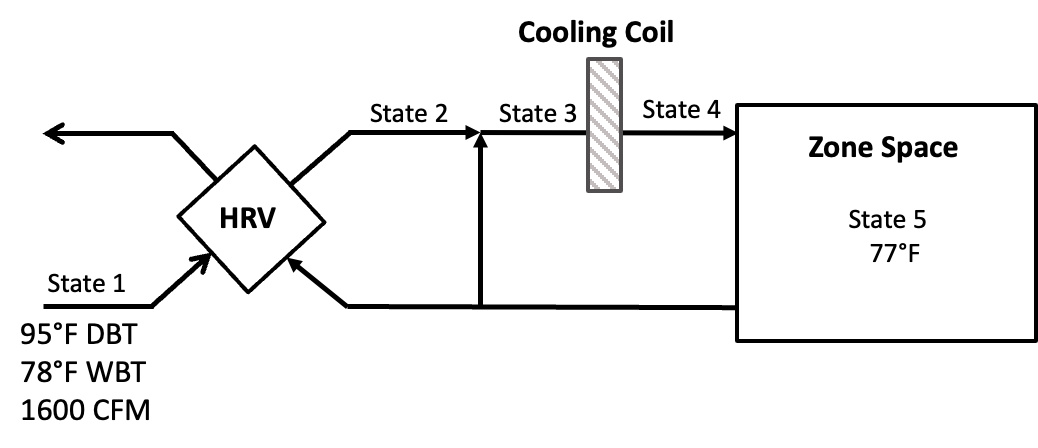

In [ ]:
display(Image(filename='Midterm_P1.jpg')) 

In [15]:
P_atm = 14.7
V_dot_ven = 1600 #cfm
T_db_1 = 95 
T_wb_1 = 78
RH_1 = RH_ptb(P_atm,T_db_1,T_wb_1)
w_1 = W_ptb(P_atm,T_db_1,T_wb_1)
v_1 = v_ptb(P_atm,T_db_1,T_wb_1)
m_dot_ven = V_dot_ven * 60 / v_1
print(m_dot_ven)

6688.238198267943


In [17]:
T_db_4 = 50
RH_4 = 100
h_4 = h_ptr(P_atm,T_db_4,RH_4)
v_4 = v_ptr(P_atm,T_db_4,RH_4)
w_4 = W_ptr(P_atm,T_db_4,RH_4)

T_db_5 = 77
h_x = h_ptw(P_atm,T_db_5,w_4)
print(h_x)


Q_zone_sen = 500000 * 0.8
Q_zone_lat = 500000 * 0.2
m_dot_tot = Q_zone_sen/(h_x - h_4)
m_dot_cir = m_dot_tot - m_dot_ven
print ('m_dot_tot',m_dot_tot,'lbm/hr')
print ('m_dot_cir',m_dot_cir,'lbm/hr')

h_5 = Q_zone_lat/m_dot_tot + h_x
w_5 = W_pth(P_atm, T_db_5, h_5) 
RH_5 = RH_pth(P_atm, T_db_5, h_5) 
print(RH_5, '%')


26.83400869150948
m_dot_tot 60869.42666461641 lbm/hr
m_dot_cir 54181.18846634847 lbm/hr
46.25730746934375 %


In [19]:
# mixing
T_db_5 = 77
eta = 0.85
T_db_2 = T_db_1 - eta * (T_db_1 - T_db_5)
w_2 = w_1
RH_2 = RH_ptw(P_atm, T_db_2, w_2)
h_2 = h_ptw(P_atm, T_db_2, w_2)
print(T_db_2,'F')
print(RH_2,'%')

79.7 F
76.80085218036619 %


In [ ]:
w_3 = (m_dot_ven * w_2 + m_dot_cir * w_5)/m_dot_tot
h_3 = (m_dot_ven * h_2 + m_dot_cir * h_5)/m_dot_tot


In [21]:
Q_coil_tot = m_dot_tot * (h_3-h_4)
h_c = h_ptw(P_atm, T_db_3, w_4)
Q_coil_sen = m_dot_tot * (h_c-h_3)
Q_coil_lat = m_dot_tot * (h_4-h_c)
print(Q_coil_sen)
print(Q_coil_lat)
print(Q_coil_tot)

NameError: name 'T_db_3' is not defined

### Problem 2: Ductwork System Design and Analysis
A ductwork system is designed to distribute air throughout a building, with all duct sections having a roughness height of ε = 0.0003 ft. The following calculations and analyses are required:\
(a) determine the appropriate diameter for each straight duct section using the Equal Friction Method, ensuring that the maximum friction rate does not exceed 0.1 inH2O/100 ft of duct (2 points);\
(b) calculate the total pressure loss across the entire duct system (2 points);\
(c) identify the locations where the Butterfly Dampers should be installed at the ends of the ducts and determine the required damper settings (in degrees) for each installed damper to achieve balanced airflow distribution across the system (3 points);\
(d) calculate the minimum fan pressure required to overcome the system losses and determine the ideal power requirement for the fan (2 points).

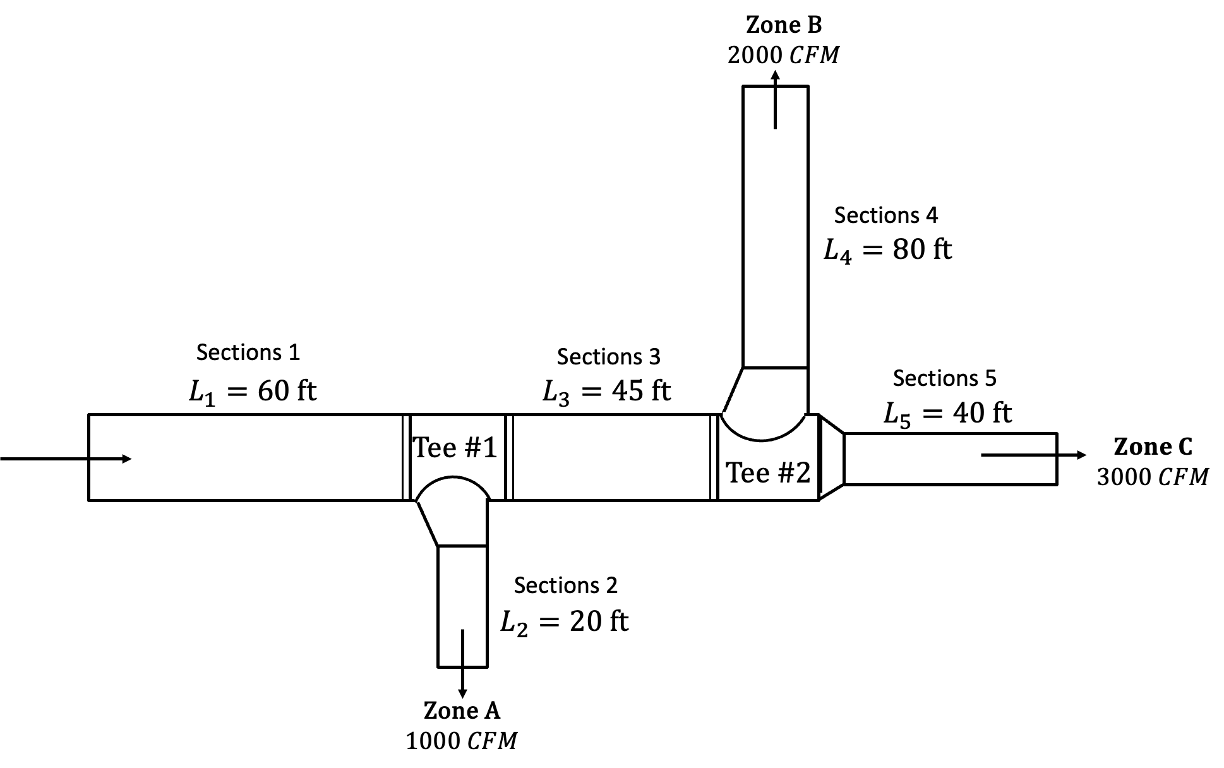

In [12]:
display(Image(filename='Midterm_P2.jpg')) 

In [23]:
C_tee_1_turn = 2.5
C_tee_1_str = 0.14
C_tee_2_turn = 0.58
C_tee_2_str = 0.14
C_diffuser = 0.1

In [42]:
# a) determine the duct size:
D_1 = 28 # [in]
D_2 = 14 # [in]
D_3 = 26 # [in]
D_4 = 18 # [in]
D_5 = 22 # [in]

L_1 = 60 #[ft]
L_2 = 20 #[ft]
L_3 = 45 #[ft]
L_4 = 80 #[ft]
L_5 = 40 #[ft]

V_dot_1 = 6000 #[ft]
V_dot_2 = 1000 #[ft]
V_dot_3 = 5000 #[ft]
V_dot_4 = 2000 #[ft]
V_dot_5 = 3000 #[ft]
# calculte the speed for each section
A_1 = math.pi * (D_1/12)**2/4
A_2 = math.pi * (D_2/12)**2/4 
A_3 = math.pi * (D_3/12)**2/4 
A_4 = math.pi * (D_4/12)**2/4 
A_5 = math.pi * (D_5/12)**2/4
# calculate the velocity
v_1 =  V_dot_1/60/A_1 
v_2 =  V_dot_2/60/A_2
v_3 =  V_dot_3/60/A_3
v_4 =  V_dot_4/60/A_4
v_5 =  V_dot_5/60/A_5

In [69]:
# 2.1) major pressure drop for each sction:
f = 0.015
DP_1 = f * (L_1 / (D_1 / 12)) * (rho_air * v_1**2 / 2) * 0.005974451 # inH2O
DP_2 = f * (L_2 / (D_2 / 12)) * (rho_air * v_2**2 / 2) * 0.005974451 # inH2O
DP_3 = f * (L_3 / (D_3 / 12)) * (rho_air * v_3**2 / 2) * 0.005974451 # inH2O
DP_4 = f * (L_4 / (D_4 / 12)) * (rho_air * v_4**2 / 2) * 0.005974451 # inH2O
DP_5 = f * (L_5 / (D_5 / 12)) * (rho_air * v_5**2 / 2) * 0.005974451 # inH2O


In [70]:
data = {
    "Duct Segment": ["Section 1", "Section 2", "Section 3","Section 4","Section 5"],
    "L [ft]": [L_1, L_2, L_3, L_4, L_5],
    "V [CFM]": [V_dot_1, V_dot_2, V_dot_3, V_dot_4, V_dot_5],
    "D [in]": [D_1, D_2, D_3, D_4, D_5],
    "A [ft2]": [A_1, A_2, A_3, A_4, A_5],
    "v [ft/s]": [v_1, v_2, v_3, v_4, v_5],
    "DP [ft2]": [DP_1, DP_2, DP_3, DP_4, DP_5]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display table
df

,Duct Segment,L [ft],V [CFM],D [in],A [ft2],v [ft/s],DP [ft2]
0,Section 1,60,6000,28,4.276057,23.386032,0.047262
1,Section 2,20,1000,14,1.069014,15.590688,0.014003
2,Section 3,45,5000,26,3.687008,22.601885,0.035656
3,Section 4,80,2000,18,1.767146,18.862808,0.063772
4,Section 5,40,3000,22,2.639810,18.940754,0.026305


In [72]:
# 2.2) minor pressure drop for fittings:
DP_tee_1_turn = C_tee_1_turn * (rho_air * v_1**2 / 2) * 0.005974451
DP_tee_1_str = C_tee_1_str * (rho_air * v_1**2 / 2) * 0.005974451
DP_tee_2_turn = C_tee_2_turn * (rho_air * v_3**2 / 2) * 0.005974451
DP_tee_2_str = C_tee_2_str * (rho_air * v_3**2 / 2) * 0.005974451
DP_diffuser_2 = C_diffuser * (rho_air * v_2**2 / 2) * 0.005974451
DP_diffuser_5 = C_diffuser * (rho_air * v_4**2 / 2) * 0.005974451
DP_diffuser_6 = C_diffuser * (rho_air * v_5**2 / 2) * 0.005974451

# Calculate the pressure drop
DP_1_3 = DP_1 + DP_tee_1_turn + DP_2 #+ DP_diffuser_2
DP_1_5 = DP_1 + DP_tee_1_str + DP_3 + DP_tee_2_turn + DP_4 + DP_diffuser_5
DP_1_6 = DP_1 + DP_tee_1_str + DP_3 + DP_tee_2_str + DP_5 + DP_diffuser_6



In [73]:
data = {
    "DP [inH2O]": [DP_tee_1_str,DP_tee_1_turn,DP_tee_2_str,DP_tee_2_turn]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display table
df

,DP [inH2O]
0,0.017154
1,0.306325
2,0.016023
3,0.066381


In [61]:
data = {
    "DP [ft]": [DP_1_3, DP_1_5,DP_1_6]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display table
df

,DP [ft]
0,0.367590
1,0.238197
2,0.150437
